# Visual evaluation of top FFT matches based on similarity on clean data

In [1]:
import numpy as np
import sys
import csv
import scipy.io as sio
from scipy.fftpack import fft, ifft
from sklearn.metrics import mean_squared_error
from math import sqrt
import os
import operator
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Image

In [2]:
%matplotlib inline

In [3]:
#base_dir = '/home/ibanez/data/amnh/darwin_notes/'
base_dir = '/data/amnh/darwin/'
curves_fft_dir = base_dir + 'image_csvs_fft/'
fft_similarity_dir = base_dir + 'fft_similarity_clean/'
base_image_dir = base_dir + 'images/'
base_fft_dir = base_dir + 'image_csvs_fft/'
base_csv_dir = base_dir + 'image_csvs/'

In [4]:
top_matches = pd.read_csv(base_dir + 'top_items_sorted.txt', index_col=False, header=None, sep=' ');
top_matches.columns = ["image1","image2","fft_score"]
top_matches.head()

,image1,image2,fft_score
0,MS-DAR-00048-000-00189_south,MS-DAR-00048-000-00189_north_fft.mat,0.999921
1,MS-DAR-00089-000-00017_north,MS-DAR-00205-00002-000-00431_north_fft.mat,0.999893
2,MS-DAR-00087-000-00010_south,MS-DAR-00087-000-00008_north_fft.mat,0.999853
3,MS-DAR-00085-000-00150_south,MS-DAR-00084-00002-000-00307_north_fft.mat,0.999843
4,MS-DAR-00209-00009-000-00088_south,MS-DAR-00209-00009-000-00168_north_fft.mat,0.999837


In [5]:
def save_match(row_index):
    with open("/data/amnh/darwin/confirmed_matches.csv", "a+") as f:        
        image1_basename = top_matches["image1"][row_index]
        image2_basename = top_matches["image2"][row_index]
        fft_score = top_matches["fft_score"][row_index]
        print(image1_basename, image2_basename, fft_score)
        image1_filename = image1_basename[:-6] + '.jpg'
        image2_filename = image2_basename[:-14] + '.jpg'
        print(image1_filename)
        print(image2_filename)
        
        if 'south' in image1_basename:
            f.write("{},{},{}\n".format(image2_filename, image1_filename, fft_score))
        else:
            f.write("{},{},{}\n".format(image1_filename, image2_filename, fft_score))

In [6]:
def check_match_curves(row_index):
    image1_basename = top_matches["image1"][row_index]
    image2_basename = top_matches["image2"][row_index]
    fft_score = top_matches["fft_score"][row_index]
    fft1_filename = base_fft_dir + image1_basename + '_fft.mat'
    fft2_filename = base_fft_dir + image2_basename
    curve1_filename = base_csv_dir + image1_basename + '.csv'
    curve2_filename = base_csv_dir + image2_basename[:-8] + '.csv'
    if 'south' in image1_basename and 'south' in image2_basename:
        print('CONFLICTING BORDERS!')
        return
    if 'north' in image1_basename and 'north' in image2_basename:
        print('CONFLICTING BORDERS!')
        return
    fft1 = sio.loadmat(fft1_filename)['fft']
    fft2 = sio.loadmat(fft2_filename)['fft']
    curve1restored = np.real(ifft(fft1))
    curve2restored = np.real(ifft(fft2))
    curve1xy = pd.read_csv(curve1_filename)
    curve2xy = pd.read_csv(curve2_filename)
    curve1xyn = curve1xy - curve1xy.mean()
    curve2xyn = curve2xy - curve2xy.mean()
    curve1y = curve1xyn.ix[:,1] 
    curve2y = curve2xyn.ix[:,1]
    commonsize = min(curve1y.size, curve2y.size)
    curve1yt = curve1y[:commonsize]
    curve2yt = curve2y[:commonsize]
    rms = sqrt(mean_squared_error(curve1yt,curve2yt))
    print(rms)
    print(curve1_filename)
    print(curve2_filename)
    plt.figure()
    plt.plot(curve1y)
    plt.plot(curve2y)

In [7]:
def compute_match_curves(row_index):
    image1_basename = top_matches["image1"][row_index]
    image2_basename = top_matches["image2"][row_index]
    fft_score = top_matches["fft_score"][row_index]
    image1_filename = image1_basename[:-6] + '.jpg'
    image2_filename = image2_basename[:-14] + '.jpg'
    fft1_filename = base_fft_dir + image1_basename + '_fft.mat'
    fft2_filename = base_fft_dir + image2_basename
    curve1_filename = base_csv_dir + image1_basename + '.csv'
    curve2_filename = base_csv_dir + image2_basename[:-8] + '.csv'
    curve1xy = pd.read_csv(curve1_filename)
    curve2xy = pd.read_csv(curve2_filename)
    curve1xyn = curve1xy - curve1xy.mean()
    curve2xyn = curve2xy - curve2xy.mean()
    curve1y = curve1xyn.ix[:,1] 
    curve2y = curve2xyn.ix[:,1]
    commonsize = min(curve1y.size, curve2y.size)
    curve1yt = curve1y[:commonsize]
    curve2yt = curve2y[:commonsize]
    pow1 = sqrt((curve1yt**2).sum())
    pow2 = sqrt((curve2yt**2).sum())
    conflict = False
    verified = False
    rms = sqrt(mean_squared_error(curve1yt,curve2yt))
    if 'south' in image1_basename and 'south' in image2_basename:
        conflict = True
    if 'north' in image1_basename and 'north' in image2_basename:
        conflict = True
    return rms, fft_score, min(pow1, pow2), row_index, image1_filename, image2_filename, conflict, verified

In [8]:
rmss = [compute_match_curves(x) for x in range(0,2000)]

In [9]:
review = pd.DataFrame(sorted(rmss,key=operator.itemgetter(3),reverse=True),
                     columns=["rms", "fft_score", "minpow1pow2", "row_index", "image1_filename", "image2_filename", "conflict", "verified"])

In [10]:
review = review[~review['conflict']]

In [11]:
review.head()

,rms,fft_score,minpow1pow2,row_index,image1_filename,image2_filename,conflict,verified
4,0.087589,0.513633,0.563430,1995,MS-DAR-00056-000-00203.jpg,MS-DAR-00050-000-00054.jpg,False,False
5,0.005059,0.519002,0.118997,1994,MS-DAR-00185-000-00418.jpg,MS-DAR-00029-00001-000-00082.jpg,False,False
7,0.019293,0.526031,0.301725,1992,MS-DAR-00059-00002-000-00031.jpg,MS-DAR-00209-00015-000-00074.jpg,False,False
9,0.061248,0.537222,0.508968,1990,MS-DAR-00209-00005-000-00121.jpg,MS-DAR-00077-000-00254.jpg,False,False
11,0.016648,0.560654,0.272364,1988,MS-DAR-00059-00002-000-00163.jpg,MS-DAR-00053-00001-000-00156.jpg,False,False


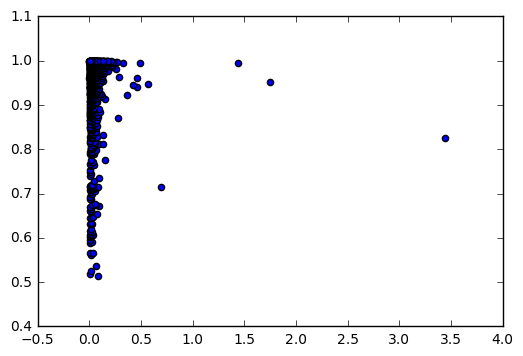

In [12]:
plt.scatter(review['rms'], review['fft_score'])

In [13]:
matches = pd.read_csv(base_dir + 'confirmed_matches.csv',
                     names = ['image1_filename', 'image2_filename', 'fft_score'])

In [14]:
matches.head()

,image1_filename,image2_filename,fft_score
0,MS-DAR-00084-00002-000-00307.jpg,MS-DAR-00085-000-00150.jpg,0.999843
1,MS-DAR-00209-00009-000-00168.jpg,MS-DAR-00209-00009-000-00088.jpg,0.999837
2,MS-DAR-00056-000-00103.jpg,MS-DAR-00055-000-00261.jpg,0.999767
3,MS-DAR-00084-00002-000-00308.jpg,MS-DAR-00085-000-00151.jpg,0.999689
4,MS-DAR-00209-00014-000-00016.jpg,MS-DAR-00209-00010-000-00084.jpg,0.999662


In [15]:
image_matches_index = pd.DataFrame(matches['image1_filename']+':'+matches['image2_filename'], columns=['image_index'])

In [16]:
image_review_index = pd.DataFrame(review['image2_filename']+':'+review['image1_filename'], columns=['image_index'])

In [17]:
for index, row in review.iterrows():
    verified = False
    image_index = row['image1_filename'] + ':' + row['image2_filename']
    if image_index in image_matches_index.image_index.values:
        verified = True
    image_index = row['image2_filename'] + ':' + row['image1_filename']
    if image_index in image_matches_index.image_index.values:
        verified = True
    review.set_value(col='verified', index=index, value=verified)

In [18]:
review.to_csv(base_dir + 'parametric_matches.csv', header=True, index=False,
              columns=["rms", "fft_score", "minpow1pow2", "row_index", "image1_filename", "image2_filename", "verified"])

In [19]:
reviewverified = review[review['verified']]
min_fft_score = min(reviewverified['fft_score'])
max_rms = max(reviewverified['rms'])
min_minpower = min(reviewverified['minpow1pow2'])

In [20]:
candidates = review[review['verified']==False]
candidates = candidates[candidates['rms'] < max_rms]
candidates = candidates[candidates['fft_score'] > min_fft_score]
candidates = candidates[candidates['minpow1pow2'] > min_minpower]

In [21]:
candidates.sort_values('row_index', ascending=False)

,rms,fft_score,minpow1pow2,row_index,image1_filename,image2_filename,conflict,verified
1646,0.068430,0.997431,4.847854,353,MS-DAR-00010-00002-000-00283.jpg,MS-DAR-00084-00002-000-00398.jpg,False,False
1673,0.056562,0.997627,2.662005,326,MS-DAR-00082-000-00314.jpg,MS-DAR-00088-000-00088.jpg,False,False
1706,0.043420,0.997828,2.675352,293,MS-DAR-00083-000-00025.jpg,MS-DAR-00018-00001-000-00077.jpg,False,False
1750,0.055262,0.998073,4.772641,249,MS-DAR-00209-00005-000-00116.jpg,MS-DAR-00208-000-00214.jpg,False,False
1868,0.025332,0.998839,3.547572,131,MS-DAR-00018-00001-000-00190.jpg,MS-DAR-00012-000-00165.jpg,False,False
1909,0.014621,0.999101,2.581176,90,MS-DAR-00081-000-00159.jpg,MS-DAR-00209-00009-000-00158.jpg,False,False
1940,0.016840,0.999316,2.807304,59,MS-DAR-00205-00007-000-00281.jpg,MS-DAR-00013-000-00030.jpg,False,False
1997,0.009677,0.999853,7.206468,2,MS-DAR-00087-000-00010.jpg,MS-DAR-00087-000-00008.jpg,False,False


0.01632206704005477
/data/amnh/darwin/image_csvs/MS-DAR-00088-000-00340_north.csv
/data/amnh/darwin/image_csvs/MS-DAR-00088-000-00342_south.csv


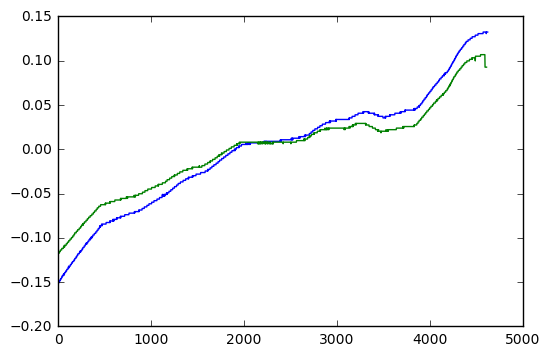

In [23]:
check_match_curves(368)

In [42]:
save_match(368)

MS-DAR-00088-000-00340_north MS-DAR-00088-000-00342_south_fft.mat 0.997299017696
MS-DAR-00088-000-00340.jpg
MS-DAR-00088-000-00342.jpg
